<a href="https://colab.research.google.com/github/MichalAdamski1/uczenie-maszynowe-w-finansach/blob/main/case2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
# u.data
ratings = pd.read_csv(
    "u.data",
    sep="\t",
    names=["userId", "movieId", "rating", "timestamp"]
)

# u.item
items_cols = ["movieId", "title", "release_date", "video_release_date", "imdb_url",
              "unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
              "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
              "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller",
              "War", "Western"]

movies = pd.read_csv(
    "u.item",
    sep="|",
    encoding="latin-1",
    names=items_cols
)


In [6]:
num_children_movies = movies[movies["Children"] == 1].shape[0]
num_children_movies


122

/tmp/ipython-input-3503368718.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=ratings_1995, palette="viridis")


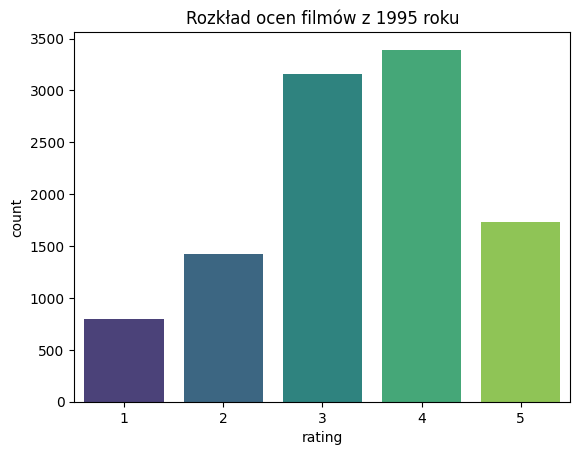

In [7]:
movies_1995 = movies[movies["release_date"].str.contains("1995", na=False)]

ratings_1995 = ratings.merge(
    movies_1995[["movieId", "title"]],
    on="movieId"
)

sns.countplot(x="rating", data=ratings_1995, palette="viridis")
plt.title("Rozkład ocen filmów z 1995 roku")
plt.show()


In [14]:

action_movies = movies[movies["Action"] == 1]

action_ratings = ratings.merge(
    action_movies[["movieId", "title"]],
    on="movieId"
)

mean_action_rating = action_ratings["rating"].mean()
print("Średnia ocen wszystkich filmów akcji:", mean_action_rating)


top3_action = (
    action_ratings.groupby("title")["rating"]
    .mean()
    .sort_values(ascending=False)
    .head(3)
)

print("\nTop 3 najwyżej oceniane filmy akcji:")
print(top3_action)


Średnia ocen wszystkich filmów akcji: 3.480245417953027

Top 3 najwyżej oceniane filmy akcji:
title
Star Wars (1977)                  4.358491
Godfather, The (1972)             4.283293
Raiders of the Lost Ark (1981)    4.252381
Name: rating, dtype: float64


In [22]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy.linalg import svd

df = ratings.copy()

users = df.userId.unique()
movies_ids = df.movieId.unique()

u2i = {u:i for i,u in enumerate(users)}
m2i = {m:i for i,m in enumerate(movies_ids)}

n_users = len(users)
n_movies = len(movies_ids)

R = np.zeros((n_users, n_movies))

for row in df.itertuples():
    R[u2i[row.userId], m2i[row.movieId]] = row.rating


# SVD
def svd_predict_matrix(R, k=20):
    U, s, Vt = svd(R, full_matrices=False)
    S = np.diag(s[:k])
    return U[:, :k] @ S @ Vt[:k, :]


# kNN with Means
movie_means = np.true_divide(R.sum(axis=0), (R != 0).sum(axis=0))

R_norm = R.copy()
for m in range(n_movies):
    R_norm[R[:, m] != 0, m] -= movie_means[m]

similarity = cosine_similarity(R_norm.T)

def predict_knn_means(user_idx, movie_idx, k):

    sims = similarity[movie_idx].copy()
    sims[movie_idx] = -1

    top_k = np.argsort(sims)[-k:]

    numer = 0
    denom = 0

    for m in top_k:
        if R[user_idx, m] != 0:
            numer += sims[m] * (R[user_idx, m] - movie_means[m])
            denom += abs(sims[m])

    if denom == 0:
        return movie_means[movie_idx]

    return movie_means[movie_idx] + numer / denom


# Cross-validation + GridSearch
def evaluate_knn(k):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmses = []

    for train_idx, test_idx in kf.split(df):
        df_train = df.iloc[train_idx]
        df_test = df.iloc[test_idx]

        R_train = np.zeros((n_users, n_movies))
        for row in df_train.itertuples():
            R_train[u2i[row.userId], m2i[row.movieId]] = row.rating

        preds = []
        trues = []

        for row in df_test.itertuples():
            u = u2i[row.userId]
            m = m2i[row.movieId]

            if R_train[u, m] == 0:
                preds.append(predict_knn_means(u, m, k))
                trues.append(row.rating)

        rmses.append(np.sqrt(mean_squared_error(trues, preds)))

    return np.mean(rmses)

results = {}

for k in range(3, 11):
    print(f"Testuję k={k} ...")
    rmse = evaluate_knn(k)
    results[k] = rmse
    print(f"  RMSE = {rmse}")

best_k = min(results, key=results.get)

print("\nNajlepsze k:", best_k)
print("RMSE:", results[best_k])


Testuję k=3 ...
  RMSE = 0.9123489102149016
Testuję k=4 ...
  RMSE = 0.8965002675568975
Testuję k=5 ...
  RMSE = 0.8833516465030303
Testuję k=6 ...
  RMSE = 0.8715231977549399
Testuję k=7 ...
  RMSE = 0.861240966059461
Testuję k=8 ...
  RMSE = 0.8523231502203632
Testuję k=9 ...
  RMSE = 0.8462920452517517
Testuję k=10 ...
  RMSE = 0.8394176965179743

Najlepsze k: 10
RMSE: 0.8394176965179743


Standardowy kNN porównuje użytkowników lub filmy bez żadnej korekty, więc jest wrażliwy na osoby, które oceniają wszystko bardzo wysoko lub bardzo nisko. kNN with Means usuwa tę stronniczość, odejmując od każdej oceny średnią użytkownika lub filmu, dzięki czemu podobieństwa i przewidywania są bardziej stabilne i realistyczne.

Wraz ze wzrostem liczby sąsiadów k od 3 do 10, błąd RMSE systematycznie maleje, co oznacza, że algorytm korzysta z bardziej stabilnych i uśrednionych informacji o podobnych filmach. Najniższy błąd uzyskano dla k=10, co sugeruje, że większa liczba sąsiadów pozwala lepiej uchwycić preferencje użytkowników w danych MovieLens 100k.

In [24]:
target_title = "NeverEnding Story III, The (1994)"
target_id = movies[movies['title'] == target_title]['movieId'].values[0]

target_idx = m2i[target_id]

sims = similarity[target_idx].copy()
sims[target_idx] = -1

top_k = sims.argsort()[-10:][::-1]

recommended = [movie_titles[i2m[idx]] for idx in top_k]

print("Rekomendacje po obejrzeniu:", target_title)
for r in recommended:
    print(" -", r)


Rekomendacje po obejrzeniu: NeverEnding Story III, The (1994)
 - Blood For Dracula (Andy Warhol's Dracula) (1974)
 - So Dear to My Heart (1949)
 - Audrey Rose (1977)
 - Davy Crockett, King of the Wild Frontier (1955)
 - True Crime (1995)
 - The Innocent (1994)
 - Daniel Defoe's Robinson Crusoe (1996)
 - Boxing Helena (1993)
 - White Man's Burden (1995)
 - Blood Beach (1981)
